In [1]:
%load_ext autoreload
%autoreload 2
% matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from tools import make_track, ols_regression
from hc_graph import hc_stock
sns.set()

In [15]:
prices = pd.read_csv(r"financial_data/yahoo_prices.csv", index_col=0, parse_dates=True).drop("SP 500", axis=1)
returns = prices.resample("7D").apply(lambda x:x[0]).pct_change().dropna()

In [20]:
sx5e = returns[["SX5E"]]
bch = returns.drop("SX5E", axis=1)

size = 52
freq = 13
bounds = (0,1)
total_weight = 1

df_weight = ols_regression(sx5e, bch, size, freq, boundaries=bounds, weight_sum=total_weight)
df_weight.head()

,FSTEMIB,CAC 40,DAX,IBEX
2001-01-08,4.807258e-01,0.066135,2.689400e-01,0.184199
2001-04-09,5.974600e-01,0.154159,5.959202e-02,0.188789
2001-07-09,6.243168e-01,0.241675,0.000000e+00,0.134008
2001-10-08,0.000000e+00,0.717226,1.106196e-16,0.282774
2002-01-07,1.387779e-17,0.672562,1.985007e-16,0.327438


In [22]:
prices_for_track = prices.loc[df_weight.index[0]:].drop("SX5E", axis=1)
replication = make_track(prices_for_track, df_weight)

df_res = prices.loc[replication.index][["SX5E"]]
df_res["OLS"] = replication

df_res = df_res / df_res.iloc[0]

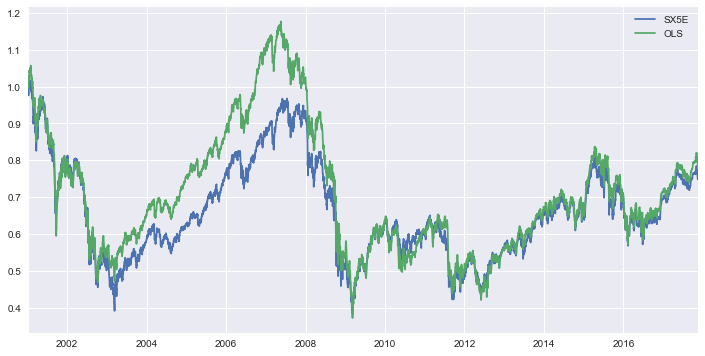

In [23]:
df_res.plot(figsize=(12,6))

In [19]:
g = hc_stock(df_res, title="OLS regression on SX5E")
g.plot(save=False, save_name='NoTable')